In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-14 08:53:41.360581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 08:53:41.360604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.MLPModel import MLPModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [6]:
# Initiating the class
deep_learner = MLPModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
layer_depth = 32,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [8]:
# Fitting the model

model = deep_learner.MLPModel()

2022-03-14 08:54:28.051753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 08:54:28.052229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 08:54:28.052305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-14 08:54:28.052362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-14 08:54:28.052412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/10
66/66 [==============================] - 1s 2ms/step - loss: 0.0099 - val_loss: 0.0067
Epoch 2/10
66/66 [==============================] - 0s 985us/step - loss: 0.0059 - val_loss: 0.0059
Epoch 3/10
66/66 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 4/10
66/66 [==============================] - 0s 961us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 5/10
66/66 [==============================] - 0s 908us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 6/10
66/66 [==============================] - 0s 950us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 7/10
66/66 [==============================] - 0s 957us/step - loss: 0.0050 - val_loss: 0.0049
Epoch 8/10
66/66 [==============================] - 0s 840us/step - loss: 0.0049 - val_loss: 0.0049
Epoch 9/10
66/66 [==============================] - 0s 867us/step - loss: 0.0049 - val_loss: 0.0049
Epoch 10/10
66/66 [==============================] - 0s 812us/step - loss: 0.0048 - val_loss: 0.0048


In [9]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                800       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

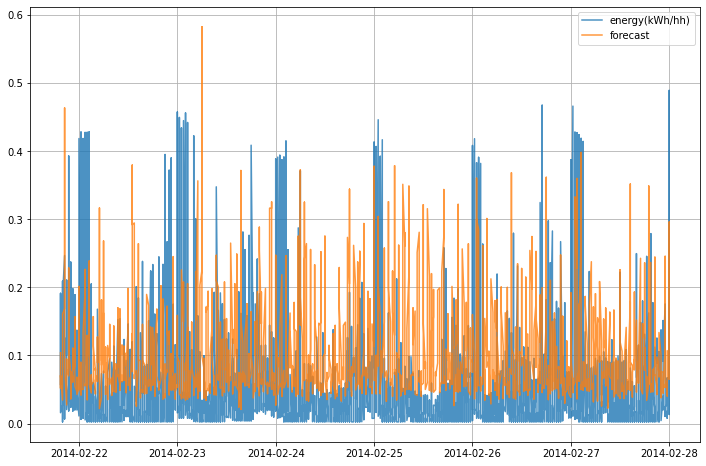

In [11]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_11218/2528746469.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


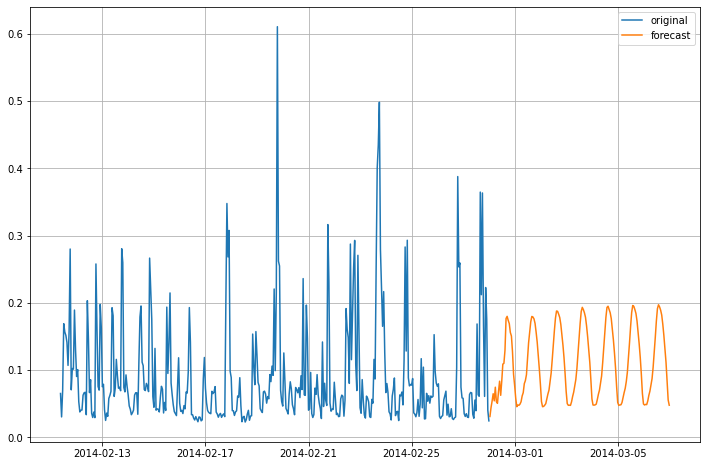

In [12]:

#Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [13]:
deep_learner.evaluateMSE()

0.004841968864168921

In [14]:
deep_learner.evaluateRMSE()

0.06958425730126694

In [15]:
deep_learner.evaluateMAE()

0.043147680176907725

In [16]:
deep_learner.evaluateMAPE()

51.234486362195646

In [17]:
yhat =deep_learner.predict()

In [ ]:
yhat